In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-aac39ad0-6575-8679-1258-778a479f152e)


# Import Everything We Need

In [ ]:
# model
from src.net import build_model

# Dataset
from src.dataloader import LinkDataset

# Graphs
import networkx as nx

# Data
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pytplot as plt

# Utils
from utils.utils import seed_everything, load_dataset_file, get_training_graph
from utils.features_extractor import compute_data_nodes, compute_data_texts, compute_features_extra

# Training
from utils.utils import find_optimal_cutoff, return_metrics
from src.training import TrainManager, predict

# Load Data

In [ ]:
# Features related to the texts
txt2feat = load_dataset_file('/content/drive/MyDrive/MLNS/data_generated/textmetafeatures.files')
# Features related to the nodes (node2vec)
node2vec_1 = load_dataset_file('/content/drive/MyDrive/MLNS/data_generated/n2v_graph_1.files')
node2vec_2 = load_dataset_file('/content/drive/MyDrive/MLNS/data_generated/n2v_graph_2.files')
node2vec_3 = load_dataset_file('/content/drive/MyDrive/MLNS/data_generated/n2v_graph_3.files')
# Data
df_train = pd.read_csv('/content/drive/MyDrive/MLNS/data/training_set.txt', sep=' ', header=None)
df_test = pd.read_csv('/content/drive/MyDrive/MLNS/data/testing_set.txt', sep=' ', header=None)
node_info = pd.read_csv('/content/drive/MyDrive/MLNS/data/node_information.csv', header=None, names=['node_id', 'date', 'title', 'authors', 'journal', 'abstract'])

# Graph Creation

In [ ]:
G = nx.DiGraph()
non_edges = []
for i in tqdm(range(len(df_train))):
  if df_train.iloc[i,2] == 1:
    G.add_edge(df_train.iloc[i,0], df_train.iloc[i,1])
  else:
    non_edges.append((df_train.iloc[i,0], df_train.iloc[i,1]))

for node in tqdm(node_info.node_id):
  if not (node in G.nodes()):
    G.add_node(node)

In [ ]:
print("There are", G.number_of_nodes(), "nodes")
print("There are", G.number_of_edges(), "edges")

There are 27770 nodes
There are 335130 edges


# Preprocessing

## Split in Train/Dev three times

In [ ]:
all_edges = list(G.edges())
non_edges_copy = non_edges.copy()

In [ ]:
seed = 42
seed_everything(seed)
np.random.shuffle(all_edges)
np.random.shuffle(non_edges_copy)

In [ ]:
print(f"Number of positive examples : {len(all_edges)}")
print(f"Number of negative examples : {len(non_edges_copy)}")

Number of positive examples : 335130
Number of negative examples : 280382


In [ ]:
number_pos_dev = int(0.06 * len(all_edges))
number_neg_dev = int(0.06 * len(non_edges_copy))
print(f"The number of pos examples : Dev {number_pos_dev} / Training {len(all_edges) - number_pos_dev}.")
print(f"The number of neg examples : Dev {number_neg_dev} / Training {len(non_edges_copy) - number_pos_dev}.")

The number of pos examples : Dev 20107 / Training 315023.
The number of neg examples : Dev 16822 / Training 260275.


In [ ]:
print(f"Proportion of positive example in data : {len(all_edges)/(len(all_edges) + len(non_edges_copy))}")
print(f"Proportion of positive example in training : {(len(all_edges) - number_pos_dev) / (len(all_edges) - number_pos_dev + len(non_edges_copy) - number_pos_dev)}")
print(f"Proportion of positive example in dev : {number_pos_dev/(number_pos_dev+number_neg_dev)}")

Proportion of positive example in data : 0.5444735439763969
Proportion of positive example in training : 0.5475822964793898
Proportion of positive example in dev : 0.5444772401093991


In [ ]:
pos_samples_dev_1 = all_edges[:number_pos_dev]
pos_samples_dev_2 = all_edges[number_pos_dev: 2*number_pos_dev]
pos_samples_dev_3 = all_edges[2*number_pos_dev: 3*number_pos_dev]
neg_samples_dev_1 = non_edges_copy[:number_neg_dev]
neg_samples_dev_2 = non_edges_copy[number_neg_dev: 2*number_neg_dev]
neg_samples_dev_3 = non_edges_copy[2*number_neg_dev: 3*number_neg_dev]

In [ ]:
assert len(pos_samples_dev_3) == len(pos_samples_dev_2) == len(pos_samples_dev_1)
assert len(neg_samples_dev_3) == len(neg_samples_dev_2) == len(neg_samples_dev_1)

In [ ]:
pos_samples_train_1 = list(set(all_edges) - set(pos_samples_dev_1))
pos_samples_train_2 = list(set(all_edges) - set(pos_samples_dev_2))
pos_samples_train_3 = list(set(all_edges) - set(pos_samples_dev_3))
neg_samples_train_1 = list(set(non_edges_copy) - set(neg_samples_dev_1))
neg_samples_train_2 = list(set(non_edges_copy) - set(neg_samples_dev_2))
neg_samples_train_3 = list(set(non_edges_copy) - set(neg_samples_dev_3))

## Slight Modification to the txt2feat
We will incoporate Journal even if we are missing values

In [ ]:
for idx, row in node_info.iterrows():
  node_id = row['node_id']
  if row['journal'] != row['journal']:
    txt2feat[node_id]['journal'] = None
  else:
    txt2feat[node_id]['journal'] = row['journal'].lower()
  if txt2feat[node_id]['authors']:
    txt2feat[node_id]['authors'] = [a.strip() for a in txt2feat[node_id]['authors']]

## Graph Split Creation + PageRank + Katz

In [ ]:
graph_1 = get_training_graph(G, pos_samples_dev_1)
pr_1 = nx.pagerank(graph_1,alpha=0.85, max_iter=200)
katz_1 = nx.katz_centrality(graph_1)

graph_2 = get_training_graph(G, pos_samples_dev_2)
pr_2 = nx.pagerank(graph_2,alpha=0.85, max_iter=200)
katz_2 = nx.katz_centrality(graph_2)

graph_3 = get_training_graph(G, pos_samples_dev_3)
pr_3 = nx.pagerank(graph_3,alpha=0.85, max_iter=200)
katz_3 = nx.katz_centrality(graph_3)

# Model/Training

## Split 1

In [ ]:
train_samples = pos_samples_train_1 + neg_samples_train_1
train_labels = [1 for x in pos_samples_train_1] + [0 for x in neg_samples_train_1]
dev_samples = pos_samples_dev_1 + neg_samples_dev_1
dev_labels = [1 for x in pos_samples_dev_1] + [0 for x in neg_samples_dev_1]

node_vec_train = compute_data_nodes(graph_1, node2vec_1, train_samples)
text_vec_train = compute_data_texts(graph_1, txt2feat, train_samples)
extra_vec_train, graph_vec_train = compute_features_extra(graph_1, txt2feat, train_samples, pr_1, katz_1)
node_vec_dev = compute_data_nodes(graph_1, node2vec_1, dev_samples)
text_vec_dev = compute_data_texts(graph_1, txt2feat, dev_samples)
extra_vec_dev, graph_vec_dev = compute_features_extra(graph_1, txt2feat, dev_samples, pr_1, katz_1)

### Training

In [ ]:
batch_size = 64
train_data = LinkDataset(node_vec_train, text_vec_train, graph_vec_train, extra_vec_train, train_labels)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=4)
dev_data = LinkDataset(node_vec_dev, text_vec_dev, graph_vec_dev, extra_vec_dev, dev_labels)
dev_loader = torch.utils.data.DataLoader(dataset=dev_data, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
class Config:
  def __init__(self):
    # Training
    self.model_dir = "/content/drive/MyDrive/MLNS/"
    self.name_model = "split_1"
    self.epochs = 100
    self.lr = 0.0008
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Models
    self.num_layers = 1
    self.num_heads = 8
    self.text_dim = 769
    self.node_dim = 129
    self.graph_dim = 7
    self.extra_dim = 3
    self.use_cuda = True

In [ ]:
cfg = Config()
model = build_model(cfg)
trainer = TrainManager(model, cfg)

In [ ]:
trainer.train_and_validate(train_loader, dev_loader)

Yes! New best validation result!
Val_F1 : 0.9231, Val AUC : 0.975, Threshold : 0.633
Yes! New best validation result!
Val_F1 : 0.9347, Val AUC : 0.9802, Threshold : 0.455
Val_F1 : 0.9149, Val AUC : 0.9692, Threshold : 0.487
Epoch 0/100 , Time : 178.527
Train_F1: 0.9064, Train_AUC : 0.9664, Threshold : 0.507


Val_F1 : 0.9287, Val AUC : 0.9781, Threshold : 0.637
Yes! New best validation result!
Val_F1 : 0.9349, Val AUC : 0.9807, Threshold : 0.411
Val_F1 : 0.9334, Val AUC : 0.9805, Threshold : 0.465
Epoch 1/100 , Time : 177.916
Train_F1: 0.9256, Train_AUC : 0.9775, Threshold : 0.494


Val_F1 : 0.934, Val AUC : 0.9804, Threshold : 0.345
Yes! New best validation result!
Val_F1 : 0.9433, Val AUC : 0.9852, Threshold : 0.418
Val_F1 : 0.9362, Val AUC : 0.9815, Threshold : 0.62
Epoch 2/100 , Time : 185.255
Train_F1: 0.9315, Train_AUC : 0.9802, Threshold : 0.486


Val_F1 : 0.9348, Val AUC : 0.9813, Threshold : 0.817
Val_F1 : 0.9412, Val AUC : 0.9841, Threshold : 0.59
Val_F1 : 0.9354, Val AUC : 0

KeyboardInterrupt: ignored

# Submission Time

In [ ]:
node_vec_test = compute_data_nodes(graph_1, node2vec_1, df_test[[0,1]].values.tolist())
text_vec_test = compute_data_texts(graph_1, txt2feat, df_test[[0,1]].values.tolist())
extra_vec_test, graph_vec_test = compute_features_extra(graph_1, txt2feat, df_test[[0,1]].values.tolist(), pr_1, katz_1)

batch_size = 64
test_data = LinkDataset(node_vec_test, text_vec_test, graph_vec_test, extra_vec_test, [1]*len(extra_vec_test))
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers=4)

# Load Best Checkpoint
model.load_state_dict(torch.load("/content/drive/MyDrive/MLNS/split_1.ckpt")["model_state"])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds = predict(test_loader, device, model)

threshold = 0.6
y_pred_final = np.where(preds >= threshold, 1, 0)

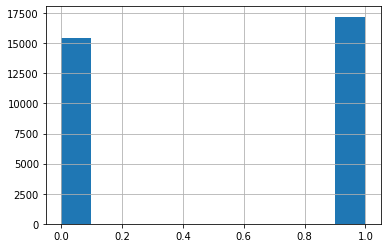

In [ ]:
df_sub = pd.read_csv('/content/drive/MyDrive/MLNS/data/random_predictions.csv')
df_sub['category'] = y_pred_final
df_sub.category.hist()

In [ ]:
df_sub.to_csv('/content/drive/MyDrive/MLNS/submissions_transformers.csv', index=False)